# Image segmentation and neural network quantization

Here are all the import statements needed for all the exercises

In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
import tensorflow.lite

Loading the Sentinel 2 dataset. Images and labels are padded to be 256x256 in size and normalized by their maximum value. 40 images are used for the train partition (X_train, Y_train) and 10 for testing (X_test, Y_test)

In [52]:
loaded = np.load('sentinel2.npz')
X = loaded['X'].astype(np.float32)
Y = loaded['Y'].astype(np.float32)
X = np.pad(X, ((0, 0), (3, 3), (3, 3), (0, 0)))
Y = np.pad(Y, ((0, 0), (3, 3), (3, 3), (0, 0)))
X_train = X[:40] / np.max(X[:40])
X_test = X[40:] / np.max(X[:40])
Y_train = Y[:40]
Y_test = Y[40:]

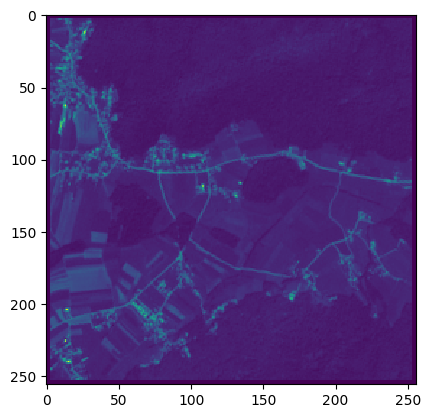

In [53]:
img_index = 10
band = 1
plt.figure()
img_rgb = X[img_index, :, :, band]
plt.imshow(img_rgb, interpolation='nearest')
plt.show()

**[TODO]** Implement the U-net neural network for segmentation as drawn in the lab document.

In [55]:
def conv_layer(features, stride, k_regularizer=tf.keras.regularizers.l2(0.01)):
    return tf.keras.layers.Conv2D(features,
                                  (5, 5),
                                  strides=(stride, stride),
                                  padding='same',
                                  activation='relu',
                                  kernel_regularizer=k_regularizer)

# def conv_layer(inputs, features, stride, k_regularizer=tf.keras.regularizers.l2(0.01)):
#     h = tf.keras.layers.Conv2D(features,
#                                (5, 5),
#                                strides=(stride, stride),
#                                padding='same',
#                                # activation='relu',
#                                kernel_regularizer=k_regularizer)(inputs)
#     h = tf.keras.layers.BatchNormalization(synchronized=True)(h)
#     return tf.keras.layers.Activation('relu')(h)

In [56]:
N = 2
inputs = tf.keras.layers.Input(shape=(256, 256, 12))
# Building h10
h1 = conv_layer(32, 1)(inputs)
h1 = tf.keras.layers.Dropout(0.3)(h1)
h1 = conv_layer(64, 1)(h1)
h10 = tf.keras.layers.Dropout(0.3)(h1)
# Building h20
h2 = conv_layer(64, 2)(h10)
h20 = tf.keras.layers.Dropout(0.3)(h2)
# Building h30
h3 = conv_layer(64, 2)(h20)
h3 = tf.keras.layers.Dropout(0.3)(h3)
h3 = conv_layer(64, 1)(h3)
h3 = tf.keras.layers.Dropout(0.3)(h3)
h30 = tf.keras.layers.UpSampling2D()(h3)
# Building h21
h2 = tf.keras.layers.Concatenate()([h20, h30])
h2 = conv_layer(64, 1)(h2)
h2 = tf.keras.layers.Dropout(0.3)(h2)
h21 = tf.keras.layers.UpSampling2D()(h2)
# Building h11
h1 = tf.keras.layers.Concatenate()([h10, h21])
h1 = conv_layer(64, 1)(h1)
h11 = tf.keras.layers.Dropout(0.3)(h1)
# h11 = tf.keras.layers.Conv2D(64,
#                              (5, 5),
#                              padding='same',
#                              # activation='relu',
#                              kernel_regularizer=tf.keras.regularizers.l2(0.01))(h11)
# Classification
outputs = tf.keras.layers.Dense(N, activation='softmax')(h11)

**[TODO]** Compile and train the model (might take some time...)

In [59]:
# Compiling
if tf.io.gfile.exists('./models/cultivated_recognition'):
    model = tf.keras.models.load_model('./models/cultivated_recognition')
    print('Model loaded!')
else:
    model = tf.keras.Model(inputs, outputs)    
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model loaded!


In [58]:
# Training
model.fit(X_train, Y_train, batch_size=32, epochs=6)

Epoch 1/6


KeyboardInterrupt: 

In [27]:
# Saving the model
model.save('./models/cultivated_recognition')

INFO:tensorflow:Assets written to: ./models/cultivated_recognition\assets


INFO:tensorflow:Assets written to: ./models/cultivated_recognition\assets


**[TODO]** Test the model on the test set and measure the accuracy.

In [60]:
model.evaluate(X_test, Y_test)

1/1 [==============================] - 7s 7s/step - loss: 2.8184 - accuracy: 0.7827


[2.8184404373168945, 0.7827316522598267]

**[TODO]** Convert model to TFLite with 8-bit weight quantization 

In [32]:
converter = tf.lite.TFLiteConverter.from_saved_model('./models/cultivated_recognition')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converted_model = converter.convert()
with open('./tfl_cultivated_recognition.tflite', 'wb') as f:
    f.write(converted_model)

**[TODO]** Test the accuracy of the quantized model by writing your own "evaluate" function. Remember that TFLite interpreter can only process one sample at a time, not a batch.

In [48]:
def tflite_evaluate(interpreter, images_data, images_labels):
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    mse = []
    for i in range(images_data.shape[0]):
        # Obtaining single data from input dataset
        test_data = images_data[i:(i + 1)]
        test_label = images_labels[i:(i + 1)]
        # Feeding data into the input tensor
        interpreter.set_tensor(input_index, test_data)
        # Running the model
        interpreter.invoke()
        prediction = interpreter.get_tensor(output_index)
        # Computing MSE portion
        mse.append((test_label - prediction) ** 2)
    return np.mean(mse)

In [49]:
# Evaluating the TFLite model
interpreter = tf.lite.Interpreter(model_content=converted_model)
interpreter.allocate_tensors()
e_MSE = tflite_evaluate(interpreter, X_test, Y_test)
print(e_MSE)

0.41987133


**[TODO]** Finetune the Keras model using quantization-aware training and measure the accuracy on the test set after actually quantizing it 

In [63]:
# Importing the model into a new quantization-aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model)
quant_aware_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [64]:
quant_aware_model.fit(X_train, Y_train, batch_size=32, epochs=6)

Epoch 1/6
2/2 [==============================] - 41s 8s/step - loss: 2.5959 - accuracy: 0.8184
Epoch 2/6
2/2 [==============================] - 36s 7s/step - loss: 1.1836 - accuracy: 0.8110
Epoch 3/6
2/2 [==============================] - 40s 11s/step - loss: 1.1628 - accuracy: 0.7695
Epoch 4/6
2/2 [==============================] - 33s 6s/step - loss: 1.3410 - accuracy: 0.8184
Epoch 5/6
2/2 [==============================] - 31s 6s/step - loss: 1.5562 - accuracy: 0.8184
Epoch 6/6
2/2 [==============================] - 36s 7s/step - loss: 1.6055 - accuracy: 0.8184


In [65]:
# Converting the new model into a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_aware_model = converter.convert()

INFO:tensorflow:Assets written to: D:\Temp\tmpdekihqln\assets


INFO:tensorflow:Assets written to: D:\Temp\tmpdekihqln\assets
D:\Steurendo\Programmazione\Python\PyCharm\SLNN\venv\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [66]:
# Evaluating the TFLite model
interpreter = tf.lite.Interpreter(model_content=converted_model)
interpreter.allocate_tensors()
e_MSE = tflite_evaluate(interpreter, X_test, Y_test)
print(e_MSE)

0.41987133
